In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Above 2 blocks were used to use GPU and connect with drive
import numpy as np
from PIL import Image
import time
import functools

import matplotlib.pyplot as plt
import matplotlib as mpl
# set things up for images display
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

In [4]:
import tensorflow as tf

from tensorflow.keras.preprocessing import image as kp_image
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

In [5]:
print(tf.__version__)

2.3.0


In [6]:
print(tf.keras.__version__)

2.4.0


In [7]:
content_path = "/content/drive/My Drive/NST_TRY_1/golden-retriever-puppy-running-outside.jpg"
style_path = "/content/drive/My Drive/NST_TRY_1/StarryNight.jpg"

# Preprocessing the images
The next function loads an image, with a little preprocessing. Image.open() is what's known as a lazy operation. The function finds the file and opens it for reading, but the image data isn't actually read from the file until you try to process it or load the data. The next group of three lines resizes the image, so that the maximum dimension in either direction is 512 (max_dimension) pixels. For example, if the image were 1,024 x 768, scale would be 0.5 (512/1,024), and this would be applied to both dimensions of the image, giving a resized image size of 512 x 384. The Image.ANTIALIAS argument preserves the best quality of the image. Next, the PIL image is converted into a NumPy array using the img_to_array() call (a method of tensorflow.keras.preprocessing).

Finally, to be compatible with later usage, the image needs a batch dimension along axis zero, (giving four dimensions altogether since the image is in color). This is achieved with the call to np.expand_dims():

In [8]:
def load_image(path_to_image):
    max_dimension = 512
    image = Image.open(path_to_image)
    longest_side = max(image.size)
    scale = max_dimension/longest_side
    image = image.resize((round(image.size[0]*scale), round(image.size[1]*scale)), Image.ANTIALIAS)
  
    image = kp_image.img_to_array(image) # keras preprocessing
  
    # Broadcast the image array so that it has a batch dimension on axis 0
    image = np.expand_dims(image, axis=0)
    return image

The next function displays an image that has been preprocessed by load_image(). Since we don't need the extra dimension for display purposes, it is removed with a call to np.squeeze(). After that, the values in the image data are converted into unsigned 8-bit integer as required by the call to plt.imshow() that follows with an optional title:

In [9]:
def show_image(image, title=None):
  # Remove the batch dimension from the image
    image1 = np.squeeze(image, axis=0)
  # Normalize the image for display 
    image1 = image1.astype('uint8')
    plt.imshow(image1)
    if title is not None:
        plt.title(title)
    plt.imshow(image1)

In [10]:
ftry1 = load_image(content_path)

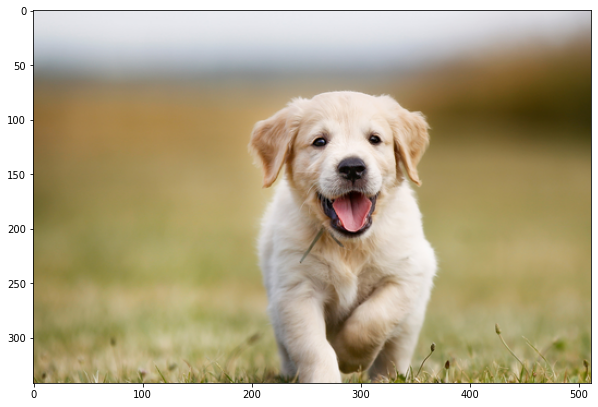

In [11]:
show_image(ftry1)

# Viewing the original images
Next, we use calls to the two preceding functions to display our content and style images, remembering that the image pixels need to be of type unsigned 8-bit integer. The plt.subplot(1,2,1) function means use a grid of one row and two columns at position one; plt.subplot(1,2,2) means use a grid of one row and two columns at position two:

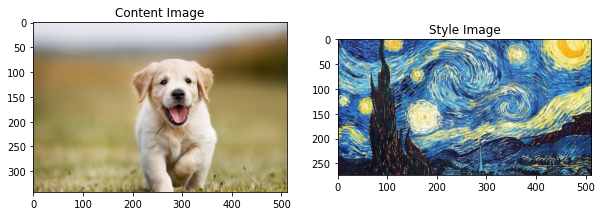

In [12]:
channel_means = [103.939, 116.779, 123.68] # means of the BGR channels, for VGG processing

plt.figure(figsize=(10,10))

content_image = load_image(content_path).astype('uint8')
style_image = load_image(style_path).astype('uint8')

plt.subplot(1, 2, 1)
show_image(content_image, 'Content Image')

plt.subplot(1, 2, 2)
show_image(style_image, 'Style Image')

plt.show()

There follows a function to load the image. As we are going to use this, as mentioned, with the vgg19 trained model, we need to preprocess our image data accordingly.

The tf.keras module provides us with a method to do this. The preprocessing here flips our RGB color image to BGR:

In [13]:
def load_and_process_image(path_to_image):
  image = load_image(path_to_image)
  image = tf.keras.applications.vgg19.preprocess_input(image)
  return image

For displaying our image, we need to have a function that takes data processed with load_and_process_image and returns the image data to its original state. This has to be done manually.

Firstly, we check that the image has the correct number of dimensions, and raise an error if this is not three or four.

The preprocessing subtracts from each channel its mean, so then the mean of the channel is zero. The value subtracted comes from the ImageNet analysis, where the means of the BGR channels are 103.939, 116.779, and 123.68, respectively.

So next, we add these values back to the BGR (color) channel to restore the original values, and then flip the BGR sequence back to RGB.

Finally, for this function, we need to make sure that our values are unsigned, 8-bit integers whose value falls in the range 0 to 255; this is achieved with the np.clip() function:

In [14]:
def deprocess_image(processed_image):
  im = processed_image.copy()
  if len(im.shape) == 4:
    im = np.squeeze(im, 0)
  assert len(im.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(im.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")

  # the inverse of the preprocessing step
  im[:, :, 0] += channel_means[0] # these are the means subtracted by the preprocessing step
  im[:, :, 1] += channel_means[1]
  im[:, :, 2] += channel_means[2]
  im= im[:, :, ::-1] # channel last

  im = np.clip(im, 0, 255).astype('uint8')
  return im

In [15]:
# The feature maps are obtained from this content layer
content_layers = ['block5_conv2']

# Style layers we need
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
               ]

number_of_content_layers = len(content_layers)
number_of_style_layers = len(style_layers)

# Using the VGG19 architecture
The best way to understand the next snippet is to have a look at the VGG19 architecture. Here is a good place: https://github.com/fchollet/deep-learning-models/blob/master/vgg19.py (about half way down the page).

Here, you will see that VGG19 is a fairly straightforward architecture, consisting of blocks of convolutional layers with a max pooling layer at the end of each block.

For the content layer, we use the second convolutional layer in block5. This highest block is used because the earlier blocks have feature maps more representative of individual pixels; higher layers in the network capture the high-level content in terms of objects and their arrangement in the input image, but do not constrain the actual exact pixel values of the reconstruction (see Gatys et al, 2015, https://arxiv.org/abs/1508.06576, cited previously).

For the style layers, we are going to use the first convolutional layer in each block of layers, that is, block1_conv1 up to block5_conv5.

The length of the content and of the style layers are then saved for later use:



In [16]:
def get_model():
 vgg_model = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
 vgg_model.trainable = False

 # Acquire the output layers corresponding to the style layers and the content layers 
 style_outputs = [vgg_model.get_layer(name).output for name in style_layers]
 content_outputs = [vgg_model.get_layer(name).output for name in content_layers]
 model_outputs = style_outputs + content_outputs
 
# Build model 
 return models.Model(vgg_model.input, model_outputs)

# Calculating the losses
We now need the losses between the contents and styles of the two images. We will be using the mean squared loss as follows. Notice here that the subtraction in image1 - image2 is element-wise between the two image arrays. This subtraction works because the images have been resized to the same size in load_image:

In [17]:
def rms_loss(image1,image2):
    loss = tf.reduce_mean(input_tensor=tf.square(image1 - image2))
    return loss

So next, we define our content_loss function. This is just the mean squared difference between what is named content and target in the function signature:



In [18]:
def content_loss(content, target):
  return rms_loss(content, target)

The style loss is defined in terms of a quantity called a Gram matrix. A Gram matrix, also known as the metric, is the dot product of the style matrix with its own transpose. Since this means that each column of the image matrix is multiplied with each row, we can think of the spatial information that was contained in the original representations to have been distributed. The result is non-localized information about the image, such as texture, shapes, and weights, that is, its style.

The code to produce gram_matrix is as follows:

In [19]:
def gram_matrix(input_tensor):
  channels = int(input_tensor.shape[-1]) # channels is last dimension
  tensor = tf.reshape(input_tensor, [-1, channels]) # Make the image channels first 
  number_of_channels = tf.shape(input=tensor)[0] # number of channels
  gram = tf.matmul(tensor, tensor, transpose_a=True) # produce tensorT*tensor
  return gram / tf.cast(number_of_channels, tf.float32) # scaled by the number of channels.

So then, the style loss (where gram_target will be the Gram matrix of the style activations on the hybrid image) is simply as follows:

In [20]:
def style_loss(style, gram_target):
  gram_style = gram_matrix(style)
  return rms_loss(gram_style, gram_target) 

Next, we find the content_features and style_features representations by getting content_image and style_image and feeding them through the model. This code is in two blocks, one for content_features, and one for style_features. For the contents block, we load an image, call our model on it, and lastly, extract the feature layers that were previously assigned. The code for style_features is identical, except that we first load the style image:

In [21]:
def get_feature_representations(model, content_path, style_path):
  #Function to compute content and style feature representations.

  content_image = load_and_process_image(content_path)
  content_outputs = model(content_image)
  #content_features = [content_layer[0] for content_layer in content_outputs[:number_of_content_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[number_of_style_layers:]]


  style_image = load_and_process_image(style_path)
  style_outputs = model(style_image)
  style_features = [style_layer[0] for style_layer in style_outputs[:number_of_style_layers]]

  return style_features, content_features

Next, we need to compute the total loss. Looking at the signature of the method, we can see that, first, we pass in our model (that gives access to the intermediate layers of VGG19). Next, come loss_weights, which are the weights of each contribution of each of the loss functions (content_weight, style_weight, and total variational weight). Then, we have the initial image, that is, the image we are updating with the optimization process. This is followed by gram_style_features and the content_features, corresponding to the style layers and content layers, respectively, that we are using.

Firstly copy the style and content_weight from the method signature. Then, call the model on our initial image. Our model is directly callable because we are using eager execution, which as we have seen is the default in TensorFlow 2. This call returns all of the model output values.

Then we have two similar blocks, one for content and one for the style. For the first (content) block, get the content and style representations in our desired layers. Next, we accumulate the content losses from all content loss layers, where the contribution of each layer is equally weighted.

The second block is similar to the first block, except that here we accumulate the style losses from all style loss layers, where each contribution of each loss layer is equally weighted.

Finally, the function returns the total loss, the style loss, and the content loss, as shown in the following code:

In [22]:
def compute_total_loss(model, loss_weights, init_image, gram_style_features, content_features):
 
   style_weight, content_weight = loss_weights
   model_outputs = model(init_image)
 
   content_score = 0
   content_output_features = model_outputs[number_of_style_layers:] 
   weight_per_content_layer = 1.0 / float(number_of_content_layers)
   for target_content, comb_content in zip(content_features, content_output_features):
      content_score += weight_per_content_layer*content_loss(comb_content[0], target_content)
   content_score *= content_weight

   style_score = 0
   style_output_features = model_outputs[:number_of_style_layers]
   weight_per_style_layer = 1.0 / float(number_of_style_layers)
   for target_style, comb_style in zip(gram_style_features, style_output_features):
     style_score += weight_per_style_layer *style_loss(comb_style[0], target_style)
   style_score *= style_weight
   
   total_loss = style_score + content_score
   return total_loss, style_score, content_score

Next, we have a function that computes the gradients:

In [23]:
def compute_grads(config):
   with tf.GradientTape() as tape: 
      all_loss = compute_total_loss(**config)
    # Compute gradients wrt input image
   total_loss = all_loss[0]
   return tape.gradient(total_loss, config['init_image']), all_loss

import IPython.display

# Performing the style transfer
The function that performs style_transfer is quite long so we will present it in sections.

Since we don't want to actually train any layers in our model, just use the output values from the layers as described previously; we set their trainable properties accordingly.

Next, we get the style_features and content_features representations from the layers of our model, using the function previously defined.

And gram_style_features, using a loop over style_features, shown as follows.

Next, we initialize the image that will become the output of the algorithm, that is, the hybrid image (also known as the pastiche image), by loading the content image and converting it into a tensor:

The next line defines the required AdamOptimizer function:

We are going to save best_image and best_loss as we go along, so initialize variables to store these:

Next, we set up the dictionary of configuration values that will be passed into the compute_grads() function:

Here are the display constants:

Next, we calculate the image bounds, shown as follows:

This list will store the hybrid images:

Next, we start the main image processing loop, as follows:

So next we compute the gradients, calculate the losses, call the optimizer to apply the gradients, and clip the image to our previously calculated bounds:

We are going to save best_loss and best_image as we go along, so do this next:

Then, we conditionally save the hybrid image (for a total of 10 images), displaying it together with the training metrics:

Finally, for this function, we display all of best_image and best_loss:

Next, we call the preceding function to get best_image and best_loss (which also displays the 10 images):



In [24]:
def run_style_transfer(content_path,
                       style_path,
                       number_of_iterations=1000,
                       content_weight=1e3,
                       style_weight=1e-2):#og style weight = 1e-2, content weight = 1e3
  model = get_model() 
  
  for layer in model.layers:
    layer.trainable = False

  style_features, content_features = get_feature_representations(model, content_path, style_path)

  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

  initial_image = load_and_process_image(content_path)
  initial_image = tf.Variable(initial_image, dtype=tf.float32)

  optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

  best_loss, best_image = float('inf'), None

  loss_weights = (style_weight, content_weight)
  config = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': initial_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }

  number_rows = 2
  number_cols = 5
  display_interval = number_of_iterations/(number_rows*number_cols)

  norm_means = np.array(channel_means)
  minimum_vals = -norm_means
  maximum_vals = 255 - norm_means

  images = []

  for i in range(number_of_iterations):
    grads, all_loss = compute_grads(config)
    loss, style_score, content_score = all_loss
    optimizer.apply_gradients([(grads, initial_image)])
    clipped_image = tf.clip_by_value(initial_image, minimum_vals, maximum_vals)
    initial_image.assign(clipped_image)

    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_image = deprocess_image(initial_image.numpy())

    if i % display_interval== 0:
      # Use the .numpy() method to get the numpy image array, needs eager execution
      plot_image = initial_image.numpy()
      plot_image = deprocess_image(plot_image)
      images.append(plot_image)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_image))
      print('Iteration: {}'.format(i)) 
      print('Total loss: {:.4e}, ' 
          'style loss: {:.4e}, '
          'content loss: {:.4e} '
          .format(loss, style_score, content_score))
      
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  
  for i,image in enumerate(images):
   plt.subplot(number_rows,number_cols,i+1)
   plt.imshow(image)
   plt.xticks([])
   plt.yticks([])
 
  return best_image, best_loss

The code for this is as follows:

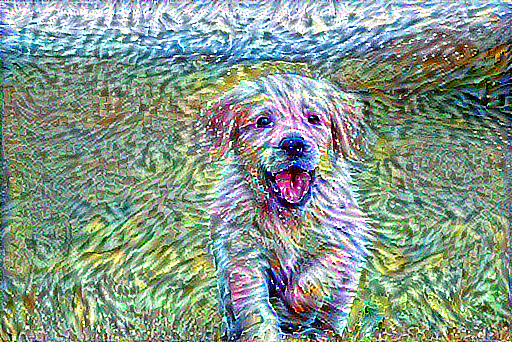

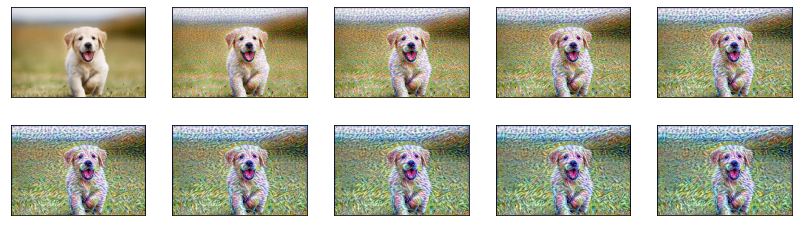

In [25]:
best_image, best_loss = run_style_transfer(content_path, style_path, number_of_iterations=100)
Image.fromarray(best_image)

Finally, we have a function that displays the content and style images together with best_image:

In [26]:
def show_results(best_image, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_image(content_path)
  style = load_image(style_path)

  plt.subplot(1, 2, 1)
  show_image(content, 'Content Image')

  plt.subplot(1, 2, 2)
  show_image(style, 'Style Image')

  if show_large_final:
    plt.figure(figsize=(10, 10))

    plt.imshow(best_image)
    plt.title('Output Image')
    plt.show()

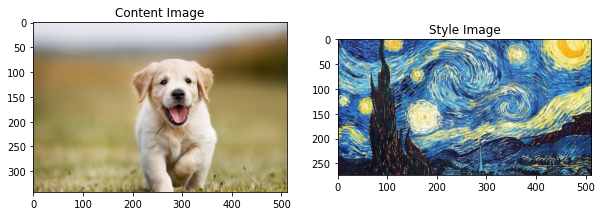

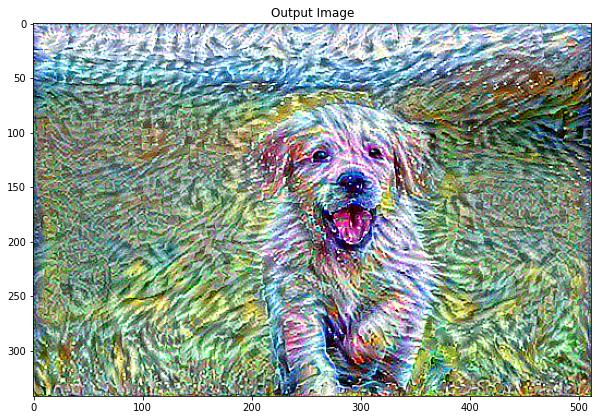

In [27]:
show_results(best_image, content_path, style_path)